In [1]:
# import os
import ray

In [2]:
import sys
print(sys.executable)


import os
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

# sys.path.append(os.path.abspath("/Users/kavina/Documents/EXTRA/madewithml/mlproject"))
sys.path.append(os.path.abspath(".."))

# # Now this will work:
# from madewithml.models import FinetunedLLM

/Users/kavina/.pyenv/versions/3.10.11/bin/python


In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2025-06-23 15:40:32,793	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


(MapBatches(preprocess) pid=10478) /Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=10478)   warnings.warn(
(MapBatches(CustomPreprocessor._transform_pandas) pid=10478) /Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(CustomPreprocessor._transform_pandas) pid=10478)   warnings.warn(
(TorchTrainer pid=10491) The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
(TorchTrainer pid=10491) S

In [4]:
ray.cluster_resources()

{'memory': 3351783015.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 1675891507.0,
 'CPU': 8.0,
 'node:127.0.0.1': 1.0}

Data Ingestion

In [5]:
import pandas as pd 

In [6]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other
...,...,...,...,...,...
759,2431,2020-10-05 12:36:02,A Survey of the State of Explainable AI for NLP,Overview of the operations and explainability ...,natural-language-processing
760,2432,2020-10-05 13:09:58,Topic Modeling with BERT,Leveraging 🤗 Transformers and a class-based TF...,natural-language-processing
761,2434,2020-10-06 02:13:01,OpenMMLab Computer Vision,MMCV is a python library for CV research and s...,computer-vision
762,2436,2020-10-06 13:29:44,Machine Learning Methods Explained (+ Examples),Most common techniques used in data science pr...,other


In [7]:
from sklearn.model_selection import train_test_split


# Split the dataset into train and val
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=42)

In [8]:
val_df.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
other                          21
mlops                          13
Name: count, dtype: int64

In [9]:
val_df.tag.value_counts() * int((1-test_size) / test_size)
# validating if value counts

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

In [10]:
# to understand the signals and nuances of our dataset

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS


In [11]:
# Find the most common tags 
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

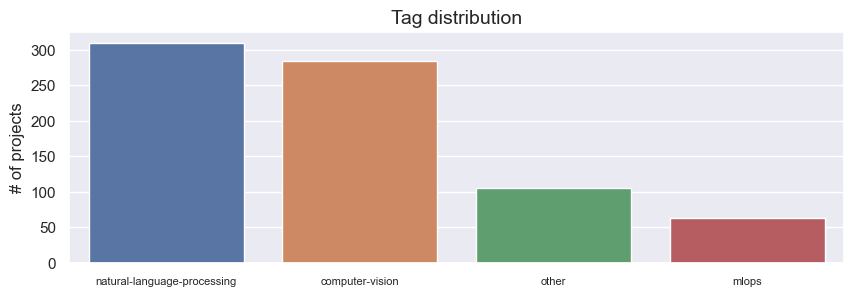

In [12]:
# Plot tag frequencies - data visualization
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

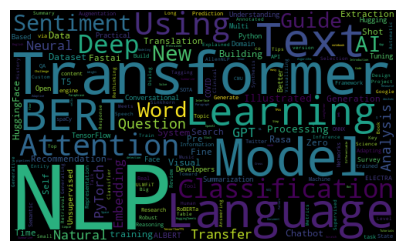

In [13]:
# Most frequent tokens for each tag using word cloud 
tag="natural-language-processing"
# tag="computer-vision"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

## Data Preprocessing

In [14]:
# preparation
import numpy as np

# View rows at index 4 and 10
print(df.loc[[4, 10]])

    id           created_on                      title   
4   25  2020-03-07 23:04:31              AttentionWalk  \
10  65  2020-03-19 18:42:05  Coloring Greyscale Images   

                                          description              tag  
4   A PyTorch Implementation of "Watch Your Step: ...            other  
10  Coloring black and white images with neural ne...  computer-vision  


In [15]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [16]:
df["text"] = df.title + " " + df.description 

In [17]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english") 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kavina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def clean_text(text, stopwords=STOPWORDS):
    text = text.lower() # turn into lower case
    
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*") # remove stopwords
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [19]:
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [20]:
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore") 
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]] 
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [21]:
df.columns

Index(['text', 'tag'], dtype='object')

In [22]:
#encoding tags 

tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'natural-language-processing': 0,
 'computer-vision': 1,
 'other': 2,
 'mlops': 3}

In [23]:
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [24]:
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,1
1,show infer tell contextual inference creative ...,1
2,awesome graph classification collection import...,2
3,awesome monte carlo tree search curated list m...,2
4,attentionwalk pytorch implementation watch ste...,2


## Encoding using a tokenizer

In [25]:
# using scibert

import numpy as np
from transformers import BertTokenizer

In [26]:
# Bert tokenizer - testing 
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [27]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [28]:
tokenize(df.head(1)) #test tokenize 

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([1])}

In [29]:
#combining the whole preprocessing technique 
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

preprocess(df=train_df, class_to_index = class_to_index)

{'ids': array([[  102,  6828,  1630, ...,     0,     0,     0],
        [  102,  2570,  7885, ...,     0,     0,     0],
        [  102,  8854,  2998, ...,     0,     0,     0],
        ...,
        [  102,  3526,   318, ...,     0,     0,     0],
        [  102,  1387, 30110, ...,     0,     0,     0],
        [  102, 10850,   142, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 2, 1, 3, 1, 2, 0, 1, 1,
        0, 3, 2, 3, 0, 0, 1, 0, 2, 0, 0, 0, 3, 1, 0, 1, 0, 1, 0, 1, 3, 1,
        2, 1, 0, 2, 3, 0, 1, 0, 1, 0, 1, 1, 3, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 2, 0, 0, 3, 1, 2, 0, 0, 0,
        1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 2, 1, 3,
        0, 1, 0, 1, 0, 0, 3, 0, 2

## Distributed PreProcessing <- Learning Wise

In [30]:
from madewithml.data import stratify_split

# Please preserve the original order of the dataset when returning results, even if it means slightly slower performance
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [31]:
import ray
import pyarrow
print(ray.__version__)
print(pyarrow.__version__)
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=42)
ds.take(1)

2.7.0
11.0.0


2025-06-23 15:40:42,102	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2025-06-23 15:40:42,121	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-06-23 15:40:42,124	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-06-23 15:40:42,125	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:42,126	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 1491,
  'created_on': datetime.datetime(2020, 6, 18, 0, 4, 34),
  'title': 'Image GPT: Generative Pretraining from Pixels',
  'description': ' Transformers trained on pixel sequences can generate coherent image completions and samples.',
  'tag': 'computer-vision'}]

In [32]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-06-23 15:40:43,772	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-06-23 15:40:43,773	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:43,773	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2025-06-23 15:40:44,649	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2025-06-23 15:40:44,649	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:44,649	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 15:40:46,268	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2025-06-23 15:40:46,270	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:46,270	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [34]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")
sample_ds.show(1)

2025-06-23 15:40:47,115	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2025-06-23 15:40:47,115	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:47,116	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': array([  102,   597, 17873, 23206,  1572,  6402,  9548, 23206, 11440,
       16754,  2449,  8709,  6402,   831,  1098,  5751, 23206,  1738,
       30126,  6402,   429,   103,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


## Training

In [35]:
import os
import random
import torch
import torch.nn as nn
from ray.data.preprocessor import Preprocessor

In [36]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [37]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=42)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [78]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class that supports loading class_to_index externally."""

    def __init__(self, class_to_index=None):
        super().__init__()
        self.class_to_index = class_to_index or {}
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def _transform_pandas(self, batch):
        return preprocess(batch, class_to_index=self.class_to_index)

## Model


In [39]:
from transformers import BertModel

In [40]:
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
embedding_dim = llm.config.hidden_size
embedding_dim

768

In [42]:
# class FinetunedLLM(nn.Module):
#     def __init__(self, llm, dropout_p, embedding_dim, num_classes):
#         super(FinetunedLLM, self).__init__()
#         self.llm = llm
#         self.dropout = torch.nn.Dropout(dropout_p)
#         self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

#     def forward(self, batch):
#         ids, masks = batch["ids"], batch["masks"]
#         seq, pool = self.llm(input_ids=ids, attention_mask=masks)
#         z = self.dropout(pool)
#         z = self.fc1(z)
#         return z

#     @torch.inference_mode()
#     def predict(self, batch):
#         self.eval()
#         z = self(inputs)
#         y_pred = torch.argmax(z, dim=1).cpu().numpy()
#         return y_pred

#     @torch.inference_mode()
#     def predict_proba(self, batch):
#         self.eval()
#         z = self(batch)
#         y_probs = F.softmax(z).cpu().numpy()
#         return y_probs

In [43]:
# Initialize model
from madewithml.models import FinetunedLLM
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters) #this basically explains whats happening

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [44]:
from ray.train.torch import get_device

Created a temporary directory at /var/folders/p4/j0h3rdp1787gz1r_bh5qzbbh0000gn/T/tmp6o1_z8p_
Writing /var/folders/p4/j0h3rdp1787gz1r_bh5qzbbh0000gn/T/tmp6o1_z8p_/_remote_module_non_scriptable.py


In [45]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [46]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [47]:
from ray.air import Checkpoint, session
from ray.air.config import CheckpointConfig, DatasetConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer, Checkpoint
import torch.nn.functional as F

num_workers = 2
resources_per_worker={"CPU": 1, "GPU": 0}

In [48]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [49]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [50]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = session.get_dataset_shard("train")
    val_ds = session.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)
    
    
    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
        checkpoint = TorchCheckpoint.from_model(model=model)
        session.report(metrics, checkpoint=checkpoint)

In [95]:
from madewithml.config import EFS_DIR

In [51]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 32,
    "num_classes": num_classes,
}

In [52]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
)

In [53]:
# Run config
# checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
# run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="~/ray_results")

from ray.air import RunConfig, CheckpointConfig
from ray.train import SyncConfig
from pathlib import Path


# Use absolute path instead of ~
checkpoint_config = CheckpointConfig(
    num_to_keep=1,
    checkpoint_score_attribute="val_loss",
    checkpoint_score_order="min"
)

run_config = RunConfig(
    name="llm",
    local_dir=str(Path("~/ray_results").expanduser()),  # ✅ Converts ~ to full path like /Users/kavina/...
    checkpoint_config=checkpoint_config,
    sync_config=SyncConfig(syncer=None)  # ✅ Optional, disables cloud syncing if you don't need it
)

## Training

In [54]:
# load and split the data
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-06-23 15:40:52,253	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2025-06-23 15:40:52,265	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-06-23 15:40:52,266	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:52,267	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2025-06-23 15:40:52,908	WARNING plan.py:567 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
2025-06-23 15:40:52,909	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2025-06-23 15:40:52,909	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:52,909	INFO streaming_exec

- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 15:40:53,642	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2025-06-23 15:40:53,643	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:53,644	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 15:40:54,463	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-06-23 15:40:54,464	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:54,464	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 15:40:56,929	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-06-23 15:40:56,930	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 15:40:56,930	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [56]:
# Dataset config
dataset_config = {
    "train": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
    "val": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
}

In [57]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

2025-06-23 15:40:59,029	WARNING data_parallel_trainer.py:283 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.


In [58]:
# Train
results = trainer.fit()

2025-06-23 15:46:18,582	INFO tune.py:1143 -- Total run time: 319.50 seconds (319.42 seconds for the tuning loop).


In [75]:
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.00010,0.438385,0.285292,1750673510,True,False,1,5bf91_00000,2025-06-23_15-41-50,...,48.595253,1,checkpoint_000000,0.5,0.0001,0.8,3,10,32,4
1,1,0.00010,0.209460,0.190293,1750673551,True,False,2,5bf91_00000,2025-06-23_15-42-31,...,90.474041,2,checkpoint_000001,0.5,0.0001,0.8,3,10,32,4
2,2,0.00010,0.124537,0.196495,1750673578,True,False,3,5bf91_00000,2025-06-23_15-42-58,...,116.727481,3,checkpoint_000002,0.5,0.0001,0.8,3,10,32,4
3,3,0.00010,0.084468,0.195631,1750673608,True,False,4,5bf91_00000,2025-06-23_15-43-28,...,147.322694,4,checkpoint_000003,0.5,0.0001,0.8,3,10,32,4
4,4,0.00010,0.064582,0.328465,1750673635,True,False,5,5bf91_00000,2025-06-23_15-43-55,...,174.404912,5,checkpoint_000004,0.5,0.0001,0.8,3,10,32,4
5,5,0.00008,0.064193,0.209136,1750673662,True,False,6,5bf91_00000,2025-06-23_15-44-22,...,201.058323,6,checkpoint_000005,0.5,0.0001,0.8,3,10,32,4
6,6,0.00008,0.063862,0.194585,1750673689,True,False,7,5bf91_00000,2025-06-23_15-44-49,...,227.524626,7,checkpoint_000006,0.5,0.0001,0.8,3,10,32,4
7,7,0.00008,0.066597,0.164291,1750673717,True,False,8,5bf91_00000,2025-06-23_15-45-17,...,255.773451,8,checkpoint_000007,0.5,0.0001,0.8,3,10,32,4
8,8,0.00008,0.031424,0.162759,1750673745,True,False,9,5bf91_00000,2025-06-23_15-45-45,...,283.615602,9,checkpoint_000008,0.5,0.0001,0.8,3,10,32,4
9,9,0.00008,0.029221,0.208865,1750673777,True,False,10,5bf91_00000,2025-06-23_15-46-17,...,315.764180,10,checkpoint_000009,0.5,0.0001,0.8,3,10,32,4


In [76]:
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/Users/kavina/ray_results/llm/TorchTrainer_5bf91_00000_0_2025-06-23_15-40-59/checkpoint_000008),
  {'epoch': 8,
   'lr': 8e-05,
   'train_loss': 0.031424188008531924,
   'val_loss': 0.1627587780356407,
   'timestamp': 1750673745,
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 9,
   'trial_id': '5bf91_00000',
   'date': '2025-06-23_15-45-45',
   'time_this_iter_s': 27.842151165008545,
   'time_total_s': 283.61560249328613,
   'pid': 10491,
   'hostname': 'Kavinas-MacBook-Air.local',
   'node_ip': '127.0.0.1',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 32,
     'num_classes': 4}},
   'time_since_restore': 283.61560249328613,
   'iterations_since_restore': 9})]

## Evaluation

In [61]:
from ray.train.torch import TorchPredictor
from sklearn.metrics import precision_recall_fscore_support

In [89]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()
        
    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}
        
    def get_preprocessor(self):
        return self.preprocessor
        
    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [90]:
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: Expected state_dict to be dict-like, got <class 'madewithml.models.FinetunedLLM'>.

In [84]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2025-06-23 17:00:44,694	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2025-06-23 17:00:44,703	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)] -> LimitOperator[limit=1]
2025-06-23 17:00:44,704	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:00:44,704	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'targets': 3}]

In [85]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2025-06-23 17:00:46,544	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2025-06-23 17:00:46,545	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:00:46,545	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [86]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])

NameError: name 'predictor' is not defined

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [82]:
# “We loaded our best model and its preprocessing logic, 
#  applied that to unseen test data, made predictions,
#  and compared them to the ground truth using metrics to measure performance.”

def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])

    # y_pred
    z = predictor.predict(data=ds.to_pandas())["predictions"]
    y_pred = np.stack(z).argmax(1)

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [83]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

NameError: name 'predictor' is not defined

## Inference


def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d
def predict_with_proba(df, predictor):
    preprocessor = predictor.get_preprocessor()
    z = predictor.predict(data=df)["predictions"]
    y_prob = torch.tensor(np.stack(z)).softmax(dim=1).numpy()
    results = []
    for i, prob in enumerate(y_prob):
        tag = decode([z[i].argmax()], preprocessor.index_to_class)[0]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [ ]:
# Preprocessor
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_df = pd.DataFrame([{"title": title, "description": description, "tag": "other"}])
predict_with_proba(df=sample_df, predictor=predictor)



## Experiment Tracking

In [120]:
import mlflow
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback
import time


In [96]:
# Config MLflow
MODEL_REGISTRY = Path(f"{EFS_DIR}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/mlflow


In [97]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [109]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-06-23 17:22:55,504	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2025-06-23 17:22:55,512	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-06-23 17:22:55,513	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:22:55,514	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [110]:
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()


2025-06-23 17:22:56,435	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2025-06-23 17:22:56,436	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:22:56,436	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 17:22:57,441	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2025-06-23 17:22:57,442	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:22:57,442	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 17:22:58,529	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-06-23 17:22:58,529	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:22:58,529	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 17:23:00,788	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-06-23 17:23:00,788	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:23:00,788	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [116]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

2025-06-23 17:23:44,574	WARNING data_parallel_trainer.py:283 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.


In [118]:
%%time
# Train
results = trainer.fit()

2025-06-23 17:25:39,180	ERROR tune_controller.py:1502 -- Trial task failed for trial TorchTrainer_db082_00000
Traceback (most recent call last):
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(PicklingError): ray::_Inner.train() (pid=11635, ip=127.0.0.1, actor_id=f251a54f759de378bd53f3cd01000000, repr=TorchTrainer)
  File "/Users/kavina/.pyenv/versio

TrainingFailedError: The Ray Train run failed. Please inspect the previous error messages for a cause. After fixing the issue (assuming that the error is not caused by your own application logic, but rather an error such as OOM), you can restart the run from scratch or continue this run.
To continue this run, you can use: `trainer = TorchTrainer.restore("/Users/kavina/ray_results/llm")`.
To start a new run that will retry on training failures, set `train.RunConfig(failure_config=train.FailureConfig(max_failures))` in the Trainer's `run_config` with `max_failures > 0`, or `max_failures = -1` for unlimited retries.

In [113]:
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.00010,0.438385,0.285292,1750673510,True,False,1,5bf91_00000,2025-06-23_15-41-50,...,48.595253,1,checkpoint_000000,0.5,0.0001,0.8,3,10,32,4
1,1,0.00010,0.209460,0.190293,1750673551,True,False,2,5bf91_00000,2025-06-23_15-42-31,...,90.474041,2,checkpoint_000001,0.5,0.0001,0.8,3,10,32,4
2,2,0.00010,0.124537,0.196495,1750673578,True,False,3,5bf91_00000,2025-06-23_15-42-58,...,116.727481,3,checkpoint_000002,0.5,0.0001,0.8,3,10,32,4
3,3,0.00010,0.084468,0.195631,1750673608,True,False,4,5bf91_00000,2025-06-23_15-43-28,...,147.322694,4,checkpoint_000003,0.5,0.0001,0.8,3,10,32,4
4,4,0.00010,0.064582,0.328465,1750673635,True,False,5,5bf91_00000,2025-06-23_15-43-55,...,174.404912,5,checkpoint_000004,0.5,0.0001,0.8,3,10,32,4
5,5,0.00008,0.064193,0.209136,1750673662,True,False,6,5bf91_00000,2025-06-23_15-44-22,...,201.058323,6,checkpoint_000005,0.5,0.0001,0.8,3,10,32,4
6,6,0.00008,0.063862,0.194585,1750673689,True,False,7,5bf91_00000,2025-06-23_15-44-49,...,227.524626,7,checkpoint_000006,0.5,0.0001,0.8,3,10,32,4
7,7,0.00008,0.066597,0.164291,1750673717,True,False,8,5bf91_00000,2025-06-23_15-45-17,...,255.773451,8,checkpoint_000007,0.5,0.0001,0.8,3,10,32,4
8,8,0.00008,0.031424,0.162759,1750673745,True,False,9,5bf91_00000,2025-06-23_15-45-45,...,283.615602,9,checkpoint_000008,0.5,0.0001,0.8,3,10,32,4
9,9,0.00008,0.029221,0.208865,1750673777,True,False,10,5bf91_00000,2025-06-23_15-46-17,...,315.764180,10,checkpoint_000009,0.5,0.0001,0.8,3,10,32,4


In [121]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

2025/06/23 17:29:06 WARNING mlflow.tracking.fluent: Cannot retrieve experiment by name llm-1750679076


,run_id,experiment_id,status,artifact_uri,start_time,end_time


In [122]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

IndexError: single positional indexer is out-of-bounds

In [ ]:
mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /tmp/mlflow/

## Hyper parameter tunning 

In [123]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [124]:
# Number of trials (small sample)
num_runs = 2

In [125]:
# Set up
set_seeds()

In [126]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-06-23 17:39:02,703	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2025-06-23 17:39:02,712	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-06-23 17:39:02,715	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:39:02,716	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [128]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2025-06-23 17:39:36,078	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2025-06-23 17:39:36,079	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:39:36,079	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 17:39:37,197	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-06-23 17:39:37,197	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:39:37,197	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2025-06-23 17:39:39,726	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-06-23 17:39:39,727	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-06-23 17:39:39,727	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [131]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

2025-06-23 17:40:54,116	WARNING data_parallel_trainer.py:283 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.


In [132]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [133]:
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR)

In [134]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)  # trade off b/w optimization and search space

In [135]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

In [136]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

In [137]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

In [138]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

In [139]:
# Tune
results = tuner.fit()


2025-06-23 17:45:22,216	ERROR tune_controller.py:1502 -- Trial task failed for trial TorchTrainer_484fccf5
Traceback (most recent call last):
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(PicklingError): ray::_Inner.train() (pid=12395, ip=127.0.0.1, actor_id=a83e4b0b919f867dbb8036c301000000, repr=TorchTrainer)
  File "/Users/kavina/.pyenv/versions/

copying /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/TorchTrainer_2025-06-23_17-43-12/TorchTrainer_484fccf5_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2025-06-23_17-43-50/result.json -> /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/mlflow/945838795901964597/7825e1a42f754a45a6ea5dc2d3a7ef9c/artifacts
copying /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/TorchTrainer_2025-06-23_17-43-12/TorchTrainer_484fccf5_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2025-06-23_17-43-50/params.pkl -> /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/mlflow/945838795901964597/7825e1a42f754a45a6ea5dc2d3a7ef9c/artifacts
copying /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/TorchTrainer_2025-06-23_17-43-12/TorchTrainer_484fccf5_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2025-06-23_17-43-50/events.out.tfevents.1750680833.Kavinas-MacBook-Air.local -> /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs

2025-06-23 17:45:22,959	ERROR tune_controller.py:1502 -- Trial task failed for trial TorchTrainer_ea5b2aad
Traceback (most recent call last):
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/kavina/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(PicklingError): ray::_Inner.train() (pid=12398, ip=127.0.0.1, actor_id=a00b2b802dcbbadf795bf9c601000000, repr=TorchTrainer)
  File "/Users/kavina/.pyenv/versions/

copying /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/TorchTrainer_2025-06-23_17-43-12/TorchTrainer_ea5b2aad_2_dropout_p=0.8943,lr=0.0001,lr_factor=0.4884,lr_patience=7.6818_2025-06-23_17-43-53/result.json -> /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/mlflow/945838795901964597/f4392dc3b3314ea89969f4b9e1c78e54/artifacts
copying /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/TorchTrainer_2025-06-23_17-43-12/TorchTrainer_ea5b2aad_2_dropout_p=0.8943,lr=0.0001,lr_factor=0.4884,lr_patience=7.6818_2025-06-23_17-43-53/params.pkl -> /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/mlflow/945838795901964597/f4392dc3b3314ea89969f4b9e1c78e54/artifacts
copying /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/TorchTrainer_2025-06-23_17-43-12/TorchTrainer_ea5b2aad_2_dropout_p=0.8943,lr=0.0001,lr_factor=0.4884,lr_patience=7.6818_2025-06-23_17-43-53/params.json -> /Users/kavina/Documents/EXTRA/madewithml/mlproject/efs/mlflow/945838795901964597/f4392dc3b3314ea899

2025-06-23 17:45:22,980	ERROR tune.py:1139 -- Trials did not complete: [TorchTrainer_484fccf5, TorchTrainer_ea5b2aad]
2025-06-23 17:45:22,981	INFO tune.py:1143 -- Total run time: 92.28 seconds (92.23 seconds for the tuning loop).


In [141]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

NameError: name 'best_trial' is not defined

In [ ]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

In [ ]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

## Serving


### Batch inference (offline)

In [145]:
import ray.data
from ray.data import ActorPoolStrategy

In [147]:
run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)
# predictor = TorchPredictor.from_checkpoint(best_checkpoint)
# preprocessor = predictor.get_preprocessor()

IndexError: single positional indexer is out-of-bounds

In [ ]:
# Batch inference
preprocessed_ds = preprocessor.transform(test_ds)
compute = ActorPoolStrategy(min_size=1, max_size=2)
outputs = preprocessed_ds.map_batches(predictor, batch_size=128, compute=compute)
np.array([d["output"] for d in outputs.take_all()])

In [ ]:
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request

In [ ]:
# Define application
app = FastAPI(
    title="Made With ML",
    description="Classify machine learning projects.", 
    version="0.1")

In [ ]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    def __init__(self, run_id):
        """Initialize the model."""
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        return {"results": results}

In [ ]:
# Run service
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id), route_prefix="/")

In [ ]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Shutdown
serve.shutdown()

In [ ]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobust:
    def __init__(self, run_id, threshold=0.9):
        """Initialize the model."""
        self.run_id = run_id
        self.threshold = threshold
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        
        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "other"

        return {"results": results}

In [ ]:
# Run service
serve.run(ModelDeploymentRobust.bind(run_id=run_id, threshold=0.9), route_prefix="/")

In [ ]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Shutdown
serve.shutdown()